# UP for Astrobee

In [37]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import time

import sys, os
sys.path.append('../..')
from models.astrobee import Model
import utils

from scipy.spatial import ConvexHull

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Model + True Dynamics + Problem + Nominal Trajectory

In [38]:
# model + initial state
model = Model()
model.reset()
s13     = np.sqrt(1./3.)
x_init  = np.array([ 9.2,0.0,5.0,  1e-4,1e-4,1e-4,  s13,0.,s13,s13,     0,0,0])  + 1e-5

[astrobee::__init__] Initializing freeflyer Model 
                             (linear, uncertain mass and inertia).
[astrobee::reset] resetting mass, J, and deltas.
[astrobee::reset] resetting mass, J, and deltas.


In [39]:
# nominal traj example
T = 20
X_nom = np.load('data/Xtraj.npy')[:,:(T+1)] #np.save('data/Xtraj', Xtraj)
U_nom = np.load('data/Utraj.npy')[:,:T] #np.save('data/Utraj', Utraj)
X_nom.shape

(13, 21)

# Propagate Uncertainty

In [40]:
N_MC = 100

## (randUP)

In [41]:
start = time.time()
Xs_randUP, Us_randUP = model.simulate_batch(x_init, X_nom, U_nom,
                                              N_MC = N_MC, 
                                              B_resample = True)
print('elapsed time = ',time.time()-start)

elapsed time =  0.003222942352294922


## (robUP!)

In [42]:
start = time.time()

ms, Js, ws = model.adv_sample_params(Xs_randUP, Us_randUP)

print('elapsed time = ',time.time()-start)

elapsed time =  0.1623058319091797


In [43]:
# resimulate
Xs_robUP, Us_robUP = model.simulate_batch(x_init, X_nom, U_nom,
                             N_MC = N_MC, B_resample=False)

## (robUP!)_2

In [44]:
model.adv_sample_params(Xs_randUP, Us_randUP)
Xs_robUP_2, Us_robUP_2 = model.simulate_batch(x_init, X_nom, U_nom,
                                              N_MC=N_MC, B_resample=False)

## Plot results

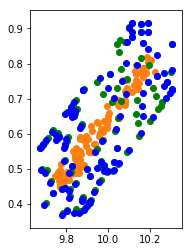

In [45]:
from utils.viz import plot_pts_2d, plot_trajs_2d
k = 10
idx = [0,1]

plt.subplot(1,2,1)
plot_pts_2d(Xs_randUP[:,:,k], idx=idx, color='C1')
plot_pts_2d(Xs_robUP[:,:,k], idx=idx, color='g')
plot_pts_2d(Xs_robUP_2[:,:,k], idx=idx, color='b')
# plt.subplot(1,2,2)
# plot_trajs_2d(Xs)

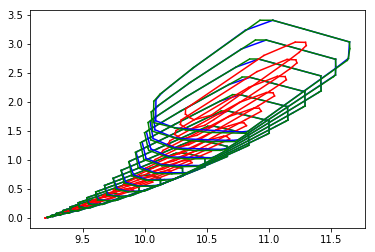

In [46]:
idx = [0,1]

# idx = [7,8]

for t in range(1,T):
    hull = ConvexHull(Xs_randUP[:,idx,t])
    for simplex in hull.simplices:
        plt.plot(Xs_randUP[simplex,idx[0],t], Xs_randUP[simplex,idx[1],t], 'r-')
        
    hull = ConvexHull(Xs_robUP[:,idx,t])
    for simplex in hull.simplices:
        plt.plot(Xs_robUP[simplex,idx[0],t], Xs_robUP[simplex,idx[1],t], 'b-')
        
    hull = ConvexHull(Xs_robUP_2[:,idx,t])
    for simplex in hull.simplices:
        plt.plot(Xs_robUP_2[simplex,idx[0],t], Xs_robUP_2[simplex,idx[1],t], 'g-')